<a href="https://colab.research.google.com/github/evgeny-kolonsky/Lab4_Nuclear/blob/main/Lab4_beta_attenuation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4. Radiation intensity attenuation measurements

**Abstract**

Radioactive samples *Strontium-90*, *Thallium-204*, *Cesium-137* and *Cobalt-60* radiation intensity $I$ is measured as a function of   width of metal plates $d$ between the sample and Geiger-Mueller (GM) counter, having distance between the sample and GM counter fixed. The metal plates "swallow" radiation. It is expected that the intensity decrease exponentially
$$
\ln \frac{I}{I_{bg}} = \mu d = \frac{\mu}{\rho} \rho d
$$
where $I_{bg}$ is background radiation, $\mu$ - attenuation coefficient, depending on decay energy, $d$ - plates width, $\rho$ - density of plates matter (Aluminium or Plumbum).  

Experimentally measured  samples of Sr-90, Tl-204,  Cs-137 and
 Co-60  are plotted on a graphs for furher discussion.

# Modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare, poisson, linregress

# Background

Background radiation was found to be Poisson distributed with intensity $I_{bg}= 0.29 s^{-1}$, see [Lab 4. Poisson test.ipynb](https://github.com/evgeny-kolonsky/Lab4_Nuclear/blob/main/Lab4_Poisson_test.ipynb).

In [2]:
I_background = 0.29 # counts /s

# Functions for repetetive actions

In [3]:
# function for rounding value by meaningful digits
# with respect to rounded error meaningful digit

def round_meaningful(value, error):
  if error <=0:
    # return unchanged and break
    return value, error

  # Power of error
  power_err = int(np.floor(np.log10(error)))

  # Digits of error in format a.bcd
  n_err = error / (10**np.floor(power_err))

  # keep 2-digits only for errors like 1.0, 1.1
  # otherwise round it up
  if n_err >= 1.2:
    n_err = np.ceil(n_err)
    error = n_err * 10** power_err

  error_rounded = np.round(error, -power_err)
  value_rounded = np.round(value, -power_err)

  return value_rounded, error_rounded

In [4]:
# Fit mu/rho.
# take linear part of data defined by Condition
# find fit.slope and fit offset of Intensity/I0 log on logarythmic scale \mu
# matter is either Al (aluminium) or Pb (lead).
# divide by matter density rho
# return fit, mu/rho and mu/rho uncertainty.

def get_murho(condition, d, I_rel, matter='Al'):
  if matter == 'Al':
    RHO = 2.7 # g/cm3 - Aluminium
  elif matter == 'Pb':
    RHO = 11.35 # g/cm3 - Plumbum
  else: # when neither Al nor B try take matter parameter as density
    RHO = matter

  logI = np.log(I_rel[condition])
  width = d[condition]
  fit = linregress(width, logI)
  mu_rho = - fit.slope / RHO
  mu_rho_err = fit.stderr / RHO
  # uncertainty
  mu_rho, mu_rho_err = round_meaningful(mu_rho, mu_rho_err)
  return mu_rho, mu_rho_err, fit, RHO




# Cobalt-60

<div>
<img src="https://www.researchgate.net/profile/Seemin-Rubab-2/publication/362273454/figure/fig3/AS:1184906306691084@1659515086052/Decay-scheme-of-Co-60-radionuclide.png" width="450">
</div>

Sample [data](https://github.com/tphlabs/data/blob/main/Lab4_Nuclear/2023_12_28/Co-60_3.txt).

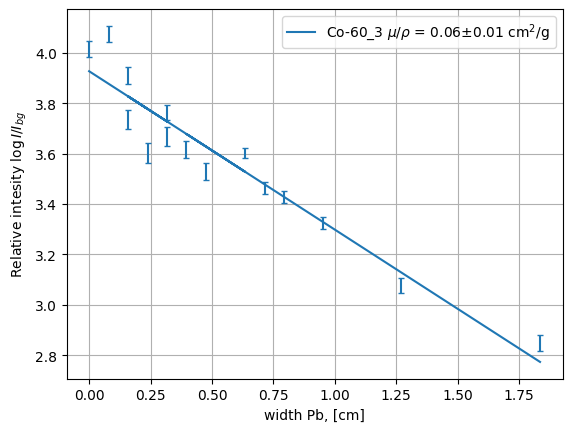

In [5]:
# station 4
# Co-60_3
# sample 2
# shelf 3
# Pb plates
URL = 'https://raw.githubusercontent.com/tphlabs/data/main/Lab4_Nuclear/2023_12_28/'
for num in [3]:
  filename = f'Co-60_{num}.txt'
  data = np.genfromtxt( filename)
  d, time, counts = data.T
  d *= 1e-4 # um -> cm
  delta = 1/np.sqrt(counts) # relative error
  I = counts / time
  I_rel = I / I_background # relative
  I_err = delta * I_rel
  log_I_rel = I_err / I_rel # error of log

  plt.errorbar(d, np.log(I_rel), yerr=log_I_rel, linestyle='', capsize=2)
  WIDTH = 2.0 # cm
  condition = d < WIDTH # exponential decay part
  mu_rho, mu_rho_err, fit, rho = get_murho(condition, d, I_rel, 'Pb')
  plt.plot(d[condition], fit.intercept + fit.slope * d[condition],
           color=plt.gca().lines[-1].get_color(), # get last color
           label=fr'Co-60_{num} $\mu/\rho$ = {mu_rho:.2f}±{mu_rho_err:.2f} cm$^2$/g')



#plt.axhline(0, color='green', label='Background')
plt.xlabel('width Pb, [cm]')
plt.ylabel(r'Relative intesity $\log I/I_{bg}$')
plt.grid()

plt.legend()

# Thallium-204

<div>
<img src="https://www.researchgate.net/publication/346533646/figure/fig3/AS:963965412724772@1606838672643/A-Schematic-of-the-Tl-decay.png" width="350">
</div>

Three samples measurements [data](https://github.com/tphlabs/data/tree/main/Lab4_Nuclear/2023_12_28).

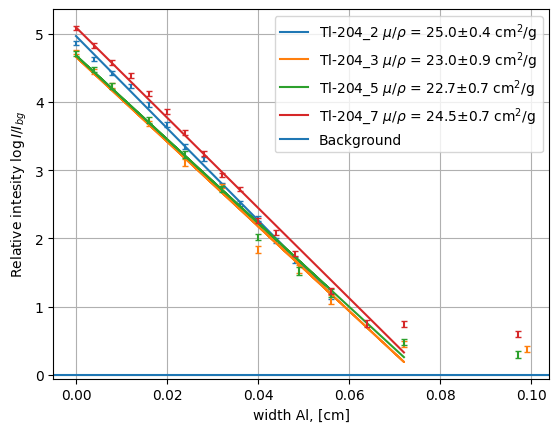

In [6]:
URL = 'https://raw.githubusercontent.com/tphlabs/data/main/Lab4_Nuclear/2023_12_28/'

for num in [2, 3, 5, 7]:
  filename = f'Tl-204_{num}.txt'
  data = np.genfromtxt( URL + filename)
  d, counts, time = data.T

  # sort by d
  idx = np.argsort(d)


  d = d * 1e-1 # mm -> cm
  delta = 1/np.sqrt(counts) # relative error
  I = counts / time
  I_rel = I / I_background # relative
  I_err = delta * I_rel
  log_I_rel = I_err / I_rel # error of log

  plt.errorbar(d, np.log(I_rel), capsize=2, yerr=log_I_rel, linestyle='')

  WIDTH = 0.08 # cm
  condition = d < WIDTH # exponential decay part
  mu_rho, mu_rho_err, fit, rho = get_murho(condition, d, I_rel, 'Al')
  plt.plot(d[condition], fit.intercept + fit.slope * d[condition],
           color=plt.gca().lines[-1].get_color(), # get last color
           label=fr'Tl-204_{num} $\mu/\rho$ = {mu_rho:.1f}±{mu_rho_err:.1f} cm$^2$/g')



plt.axhline(0,  label='Background')
plt.xlabel('width Al, [cm]')
plt.ylabel(r'Relative intesity $\log I/I_{bg}$')
plt.grid()
plt.legend()

# Strontium-90

<div>
<img src="https://radioactivity.eu.com/static/bd2ac4b2ed7ce11af31e688bfcadc8b0/d1f95/Diagramme_Strontium_En.jpg" width="500">
</div>

Four samples measurements [data](https://github.com/tphlabs/data/tree/main/Lab4_Nuclear/2023_12_26).

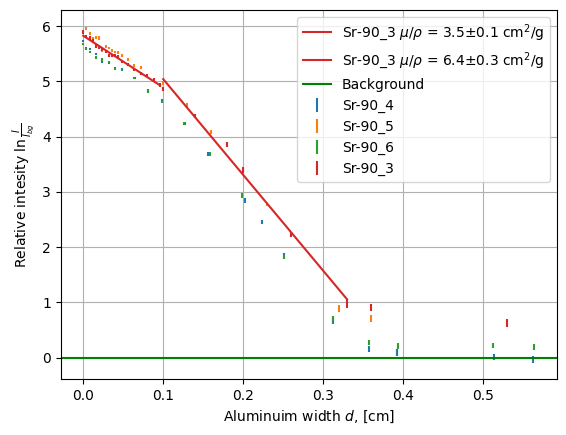

In [10]:
URL = 'https://raw.githubusercontent.com/tphlabs/data/main/Lab4_Nuclear/2023_12_26/'
for num in [4, 5, 6, 3]:
  filename = f'sr-90-{num}.txt'
  data = np.genfromtxt(URL + filename)
  d, counts, time = data.T
  d = d /10 # mm -> cm
  delta = 1/np.sqrt(counts) # relative error
  I = counts / time
  I_rel = I / I_background # relative intensity
  I_err = delta * I_rel
  log_I_rel = I_err / I_rel # error of log

  plt.errorbar(d, np.log(I_rel), yerr=log_I_rel, linestyle='', label=f'Sr-90_{num}')

WIDTH = 0.1 # cm
condition = d < WIDTH # exponential decay part
mu_rho, mu_rho_err, fit, rho = get_murho(condition, d, I_rel, 'Al')
plt.plot(d[condition], fit.intercept + fit.slope * d[condition],
          color=plt.gca().lines[-1].get_color(), # get last color
          label=fr'Sr-90_{num} $\mu/\rho$ = {mu_rho:.1f}±{mu_rho_err:.1f} cm$^2$/g')

WIDTH = (0.1, 0.35)  # cm
condition = (d >= WIDTH[0]) & (d <= WIDTH[1]) # exponential decay part
mu_rho, mu_rho_err, fit, rho = get_murho(condition, d, I_rel, 'Al')
plt.plot(d[condition], fit.intercept + fit.slope * d[condition],
          color=plt.gca().lines[-1].get_color(), # get last color
          label=fr'Sr-90_{num} $\mu/\rho$ = {mu_rho:.1f}±{mu_rho_err:.1f} cm$^2$/g')

plt.axhline(0, color='green', label='Background')
plt.xlabel('Aluminuim width $d$, [cm]')
plt.ylabel(r'Relative intesity $\ln\frac{I}{I_{bg}}$')
plt.grid()
plt.legend();


# Cesium-137

<div>
<img src="https://www.drct.com/images/nuclear/spectrum/Cs-137-Decay-Scheme-generator.jpg" width="450">
</div>

One sample [data](https://github.com/tphlabs/data/tree/main/Lab4_Nuclear/2023_12_28)

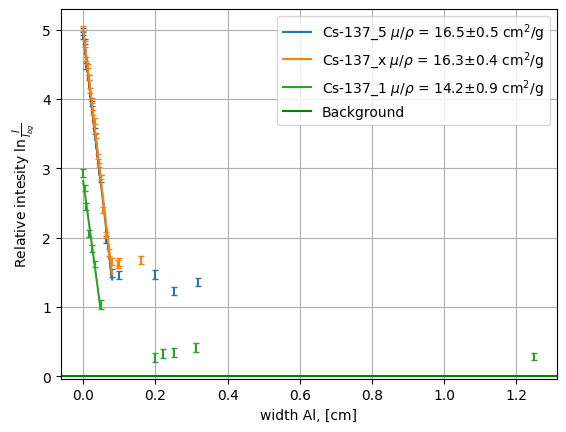

In [9]:
# station 1
# Cs-137_5
# label down
URL = 'https://raw.githubusercontent.com/tphlabs/data/main/Lab4_Nuclear/2023_12_28/'
for num in [5, 'x', 1]:
  filename = f'Cs-137_{num}.txt'
  data = np.genfromtxt(URL+ filename)
  d, counts, time = data.T
  d *= 1e-1 # mm -> cm
  delta = 1/np.sqrt(counts) # relative error
  I = counts / time
  I_rel = I / I_background # relative
  I_err = delta * I_rel
  log_I_rel = I_err / I_rel # error of log

  plt.errorbar(d, np.log(I_rel), yerr=log_I_rel, linestyle='', capsize=2)
  WIDTH = 0.09 # cm
  condition = d < WIDTH # exponential decay part
  mu_rho, mu_rho_err, fit, rho = get_murho(condition, d, I_rel, 'Al')
  plt.plot(d[condition], fit.intercept + fit.slope * d[condition],
           color=plt.gca().lines[-1].get_color(), # get last color
           label=fr'Cs-137_{num} $\mu/\rho$ = {mu_rho:.1f}±{mu_rho_err:.1f} cm$^2$/g')

plt.axhline(0, color='green', label='Background')
plt.xlabel('width Al, [cm]')
plt.ylabel(r'Relative intesity $\ln \frac{I}{I_{bg}}$')
plt.grid()

plt.legend()
